In [24]:
FILE_NAME = 'magazine_dataset.csv'

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

tf.__version__

'2.0.0'

In [25]:
def plot_series(time, series, form='-', start=0, end=None):
    plt.figure(figsize=(10, 6))
    plt.plot(time[start:end], series[start:end], form)
    plt.xlabel("Minuto")
    plt.ylabel("Ação")
    plt.grid(True)

In [26]:
data = pd.read_csv(FILE_NAME, sep=',')
data = data[['open', 'high', 'low', 'close', 'dollar_close', 'volume', 'sentiment_polarity', 'close']]
data.columns.values[3] = "y"
data.head()

,open,high,low,y,dollar_close,volume,sentiment_polarity,close
0,33.0013,33.0316,32.7213,32.8513,4.1007,0,0.06801,32.8513
1,32.8810,33.1225,32.8522,33.0411,4.0994,301337,0.06801,33.0411
2,33.0200,33.3100,33.0200,33.1300,4.0979,177100,0.06801,33.1300
3,33.1506,33.1761,32.9759,33.0006,4.0971,179428,0.06801,33.0006
4,33.0012,33.1010,32.9008,32.9112,4.0974,204443,0.06801,32.9112


In [27]:
dataset = data['y']
dataset.loc[dataset.shape[0]]= 0.0
dataset = dataset.iloc[1:]
data.iloc[:, -1] = dataset.values
dataset = data[:-1].values

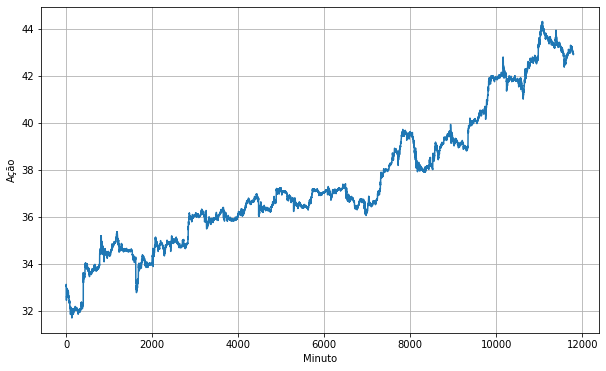

In [28]:
plot_series(np.arange(dataset.shape[0]), dataset[:, -1])

In [116]:
def windowed_dataset(series_x, series_y, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices((series_x, series_y))
    ds = ds.shuffle(shuffle_buffer)

    return ds.batch(batch_size).prefetch(1).repeat()

train_set = windowed_dataset(dataset[:, 0:-1][:, :, np.newaxis], dataset[:, -1], 3, 1000)

[[[3.21300000e+01]
  [3.21400000e+01]
  [3.20700000e+01]
  [3.20800000e+01]
  [4.09420000e+00]
  [3.21000000e+04]
  [6.80098485e-02]]

 [[3.39500000e+01]
  [3.39600000e+01]
  [3.39000000e+01]
  [3.39100000e+01]
  [4.06190000e+00]
  [1.56000000e+04]
  [1.16424108e-01]]

 [[3.45100000e+01]
  [3.45100000e+01]
  [3.44700000e+01]
  [3.44800000e+01]
  [4.06210000e+00]
  [1.67000000e+04]
  [1.72877896e-01]]] [32.04 33.92 34.49]
